In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import scipy.stats as sp
import missingno as mno
import math
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# загрузим данные 
df = pd.read_csv(r'C:\Users\anyur\healthcare-dataset-stroke-data.csv')

### Описание датасета

Этот набор данных используется для прогнозирования вероятности инсульта у пациента на основе таких входных параметров как пол, возраст, различные заболевания и статус курения, найти его можно [по ссылке](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

**Описание переменных**

`id:` уникальный идентификатор

`gender:` "Male", "Female" или "Other"

`age:` возраст пациента

`hypertension:` 0, если у пациента нет гипертонии, 1, если у пациента есть гипертония

`heart_disease:` 0, если у пациента нет никаких сердечных заболеваний, 1, если у пациента есть сердечные заболевания

`ever_married:` "No" или "Yes"

`work_type:` "children", "Govt_jov", "Never_worked", "Private" или "Self-employed"

`Residence_type:` "Rural" или "Urban"

`avg_glucose_level:` средний уровень глюкозы в крови

`bmi:` индекс массы тела

`smoking_status:` "formerly smoked", "never smoked", "smokes" или "Unknown"*

`stroke:` 1, если у пациента был инсульт, или 0, если нет

**Примечание:** "Unknown" в smoking_status означает, что информация недоступна для данного пациента

**Задачи:** 
* Проверить следующие гипотезы:

1) Брак связан с уровенем сахара в крови

2) Брак связан с индексом массы тела

3) Уровень урбанизации связвн с уровнем сахара в крови

4) Уровень урбанизации связвн с индексом массы тела

* Обучить модель логистической регрессии предсказывать наличие инсульта

In [3]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


### Описательный анализ и чистка данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Нам не нужна переменная id, удалим ее:

In [5]:
df = df.drop(columns = {'id'})

Посчитаем базовые описательные статистики на не категориальных переменных:

In [6]:
df.describe().round(2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.0,5110.00,5110.00,4909.00,5110.00
mean,43.23,0.1,0.05,106.15,28.89,0.05
std,22.61,0.3,0.23,45.28,7.85,0.22
min,0.08,0.0,0.00,55.12,10.30,0.00
25%,25.00,0.0,0.00,77.24,23.50,0.00
50%,45.00,0.0,0.00,91.88,28.10,0.00
75%,61.00,0.0,0.00,114.09,33.10,0.00
max,82.00,1.0,1.00,271.74,97.60,1.00


Проверим данные на наличие пропущенных значений:

In [7]:
df.apply(lambda column: column.isna().sum(), axis = 0)

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<AxesSubplot:>

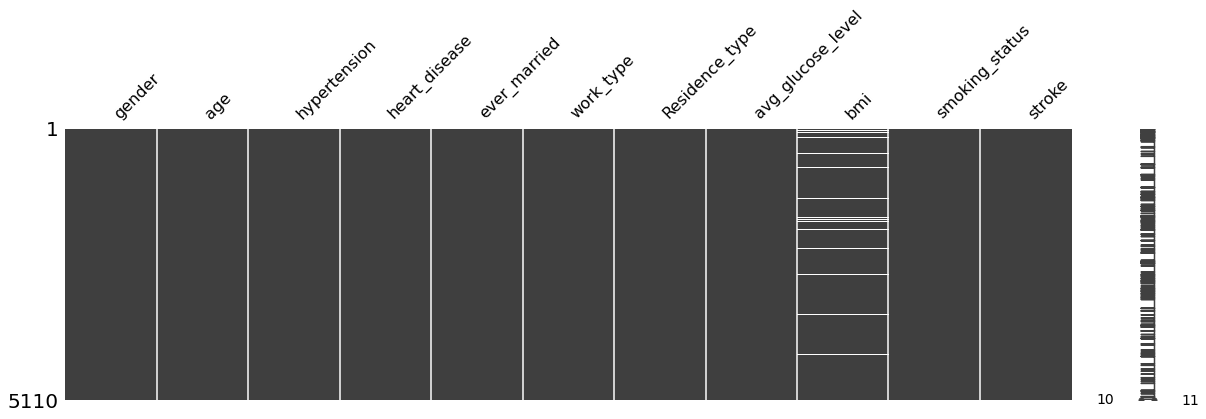

In [8]:
# еще пропуски можно визуализировать
mno.matrix(df, figsize = (20, 5))

У нас есть 201 пропуск в переменной, фиксирующей индекс массы тела, и с этим нужно что-то сделать. Самый простой и грубый вариант - удалить все строки с пропущенными значениями, вариант немного получше - заменить пропуски средними значениями. Я не буду делать ни то, ни другое, вместо этого я воспользюсь методом [Stochastic Regression Imputation](https://statisticsglobe.com/regression-imputation-stochastic-vs-deterministic/)

Для этого нужно понять, с какой переменной индекс массы тела связан сильнее всего. Посмотрим на корреляции:

<AxesSubplot:>

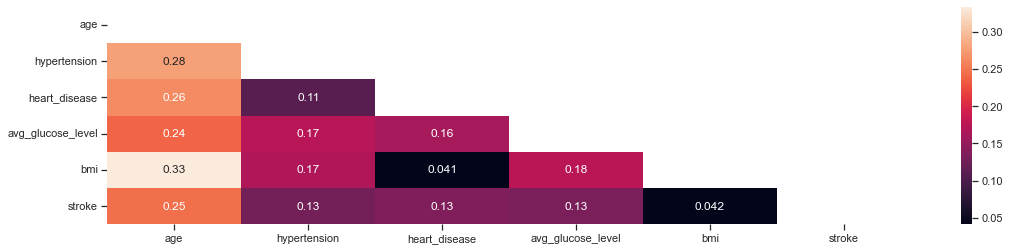

In [9]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize': (18, 4)}
sns.set_theme(style = "ticks", rc = custom_params)

sns.heatmap(df.corr(), annot = True, mask = np.triu(df.corr()))

Очень сильных связей не прослеживается. Тем не менее, индекс массы тела связан с возрастом(0.33), уровнем сахара в крови(0.18) и наличием гипертонии(0.17).

Построим модель множественной линейной регрессии, чтобы иметь возможность предсказывать значения индекса массы тела: 

In [10]:
model = ols('bmi ~ age + hypertension + avg_glucose_level', df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    bmi   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     235.0
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          1.90e-142
Time:                        23:37:49   Log-Likelihood:                -16753.
No. Observations:                4909   AIC:                         3.351e+04
Df Residuals:                    4905   BIC:                         3.354e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6123      0.31

R квадрат не большой(0.12), но значимый. Все коэффициенты при предикторах также стат. значимы. Модель, конечно, не самая мощная, но мне все равно кажется, что пропущенные значения лучше предскать слабой моделью, чем просто заменить на средние значения/удалить.

Заменим пропущенные значения с помощью метода Stochastic Regression Imputation. Библиотек с такой функцией я не нашел, поэтому реализовал руками: 

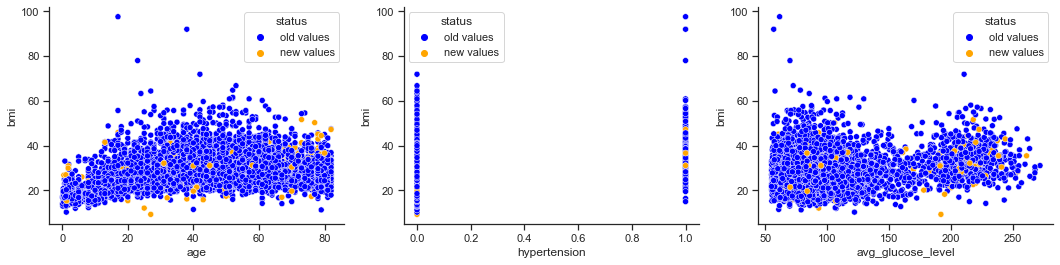

In [11]:
# сюда будем складывать значения обновленной переменной
new_variable = []
# для воспроизводимости
np.random.seed(42)

# итерируемся по строкам датафрейма
for row_number in range(len(df)):
    
    # если значение не пропущенное, то оставляем все как есть
    if not math.isnan(df['bmi'][row_number]):
        new_variable.append(df['bmi'][row_number])
    
    # если значение пропущенное, то предсказываем его и добавляем немного шума, чтобы снизить bias of deterministic regression imputation
    elif math.isnan(df['bmi'][row_number]):
        new_variable.append((model.params.Intercept 
                            + model.params.age * df['age'][row_number]
                            + model.params.hypertension * df['hypertension'][row_number]
                            + model.params.avg_glucose_level * df['avg_glucose_level'][row_number]) 
                            + float(np.random.normal(0, np.std(model.resid)))) # дабавим стохастическую компоненту

# обновим датафрейм и создадим дополнительную переменную, чтобы знать где были пропущенные значения
df['status'] = np.where(df['bmi'].isna(), 'new values', 'old values')
df['bmi'] = new_variable

# нарисуем
fig, axs = plt.subplots(1,3) 
sns.scatterplot(data = df, x = 'age', y = 'bmi', hue = 'status', ax = axs[0], palette = ['blue', 'orange'])
sns.scatterplot(data = df, x = 'hypertension', y = 'bmi', hue = 'status', ax = axs[1], palette = ['blue', 'orange'])
sns.scatterplot(data = df, x = 'avg_glucose_level', y = 'bmi', hue = 'status', ax = axs[2], palette = ['blue', 'orange'])

# удалим, она больше не нужна
df = df.drop('status', axis = 1)

Больше пропусков нет:

<AxesSubplot:>

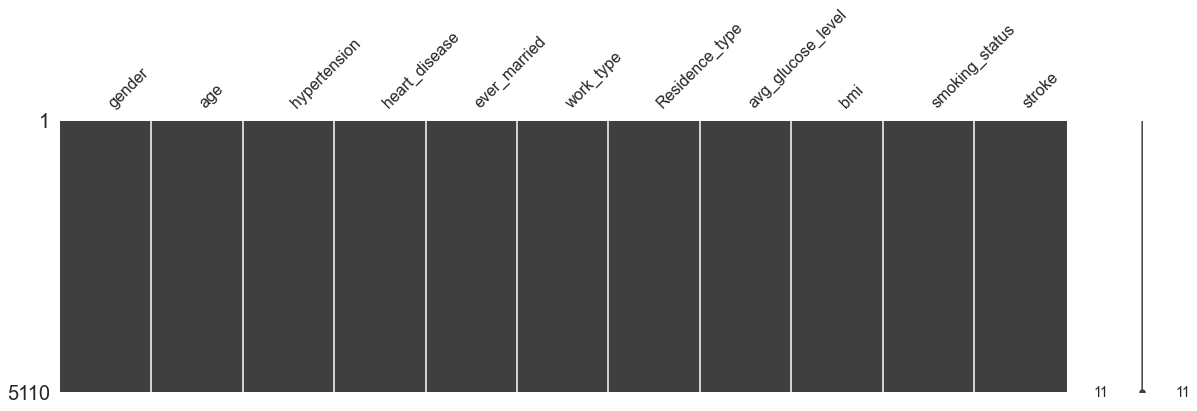

In [12]:
mno.matrix(df, figsize = (20, 5))

Посмотрим на значения категориальных признаков:

In [13]:
for i in df.loc[:,df.dtypes == 'object'].columns:
    print(df[i].unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


В переменной 'smoking_status' есть фактически пропущенные значения, помеченные как 'Unknown'. Таких значений довольно много, и они скрывают важную информацию. Далее я собираюсь сделать следующее:
1) Для всех, у кого возраст < 16 и статус курения 'Uknown', проставить 'never smoked' в статус курения, потому что это логично

2) Для всех у кого возраст > 16 и статус курения 'Uknown', проставить 'formerly smoked', 'smokes', 'never smoked', учитывая респределение этих значений в оставшейся выборке 

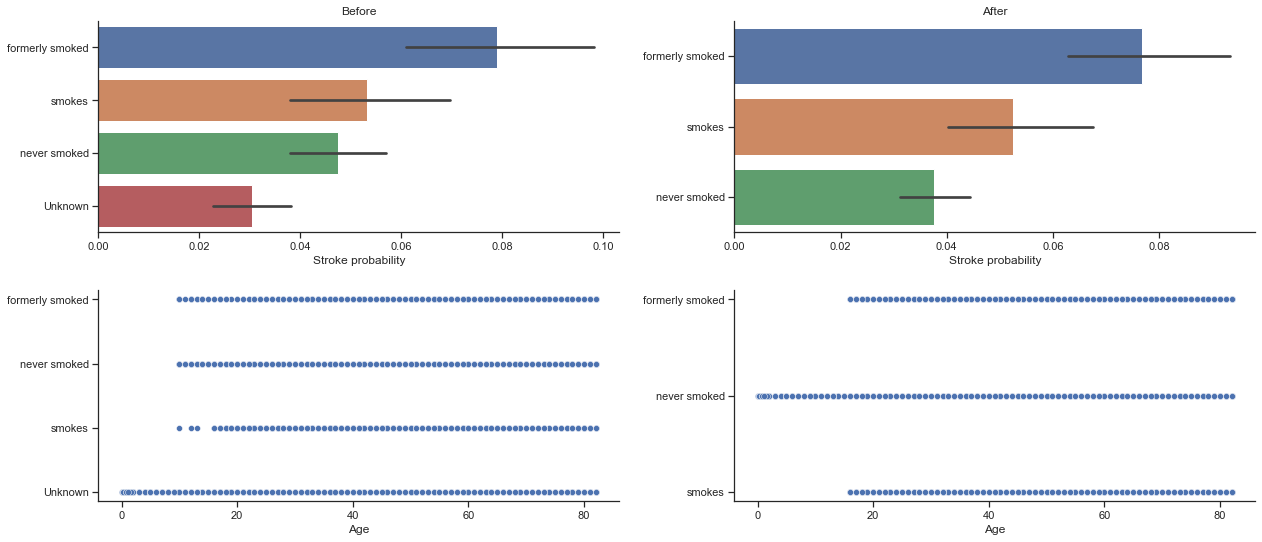

In [14]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize': (18, 8)}
sns.set_theme(style = "ticks", rc = custom_params)
fig, axs = plt.subplots(2,2)

# посмтотрим на то, как статус курения связан с вероятностью сердечного приступа
sns.barplot(x = 'stroke', y = 'smoking_status', 
            data = df, order=['formerly smoked', 'smokes', 'never smoked', 'Unknown'], ax = axs[0, 0])
axs[0, 0].set_title('Before')
axs[0, 0].set_ylabel('')
axs[0, 0].set_xlabel('Stroke probability')

# посмтотрим на то, как статус курения распределен по возрасту
sns.scatterplot(data = df, x = 'age', y = 'smoking_status', ax = axs[1, 0])
axs[1, 0].set_ylabel('')
axs[1, 0].set_xlabel('Age')

# подсчитаем, как часто встречаются те или иные значения статуса курения
status = df.query('smoking_status != "Unknown"').smoking_status.value_counts(normalize = True)

# рандомно проставим статусы
for row in range(len(df)):
    if df['smoking_status'][row] == 'Unknown':
        df['smoking_status'][row] = np.random.choice(status.index, p = status.values)
        
# для всех, у кого возраст < 16 и статус курения 'Uknown', проставим 'never smoked' в статус курения
for row in range(len(df)):
    if df['age'][row] < 16 and (df['smoking_status'][row] == 'smokes' or df['smoking_status'][row] == 'formerly smoked'):
        df['smoking_status'][row] = 'never smoked'
        
# посмотрим, что изменилось       
sns.barplot(x = 'stroke', y = 'smoking_status', 
            data = df, order=['formerly smoked', 'smokes', 'never smoked'], ax = axs[0, 1])
axs[0, 1].set_title('After')
axs[0, 1].set_ylabel('')
axs[0, 1].set_xlabel('Stroke probability')

sns.scatterplot(data = df, x = 'age', y = 'smoking_status', ax = axs[1, 1])
axs[1, 1].set_ylabel('')
axs[1, 1].set_xlabel('Age')
fig.tight_layout(pad=2)
plt.show()

Тут есть одна необычная вещь - вероятность сердечного приступа у тех кто курил в прошлом выше, чем у тех кто курит сейчас. Мне кажется, что это может быть связано с тем, что у бывших курильщиков средний возраст выше, чем у нынешних курильщиков. Проверим это:

In [15]:
df.groupby('smoking_status', as_index = False) \
    .agg({'age': np.mean})

,smoking_status,age
0,formerly smoked,53.984274
1,never smoked,38.136977
2,smokes,47.085685


Да, бывшие курильщики в среднем на 6 лет старше нынешних.

Также интересно посмотреть на распределения количественных переменных - насколько они близки к нормальному?

Для этого построим гистограммы распределений и применим тест Шапира-Вилка для количественной оценки близости к нормальному распределению:

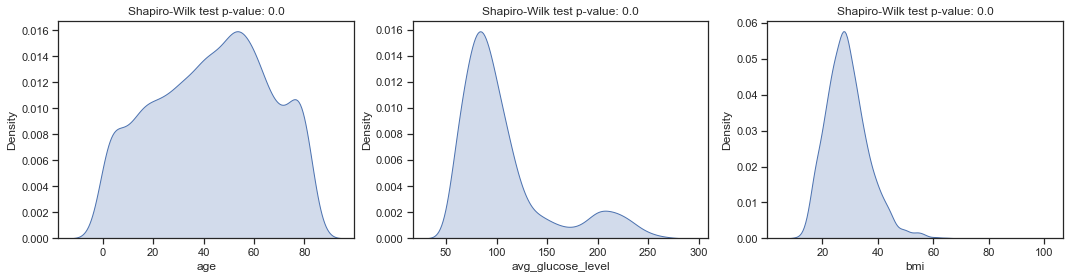

In [16]:
custom_params = {'figure.figsize': (18, 4)}
sns.set_theme(style = "ticks", rc = custom_params)
column = 0
fig, axs = plt.subplots(1,3)
for variable in df.loc[:,df.dtypes == 'float64'].columns:
    sns.kdeplot(df[variable], ax = axs[column], fill = True)
    axs[column].set_title(f'Shapiro-Wilk test p-value: {round(sp.shapiro(df[variable].sample(1000)).pvalue, 3)}')
    column += 1

Видно, что распределения уровня сахара в крови и индекса массы тела имеют ярко выраженную правую ассиметрию из-за наличия выбросов. Заменим выбросы на средние значения, но добавим к среднему значению рандомного шума из нормального распределения:

In [17]:
def outliers_killer(variable):
    
    '''
    Функция принимает на вход переменную и распечатывают информацию и кол-ве обнаруженных выбросов,
    а также возвращает переменную, где выбросы заменены на (среднее значение + шум)
    '''
    variable_name = variable.name
    variable = np.array(variable)
    standartized_var = sp.zscore(variable)
    without_outliers = variable[abs(standartized_var) < 3]
    variable[abs(standartized_var) > 3] = np.mean(without_outliers) + float(np.random.normal(0, np.std(without_outliers))) # среднее + шум
    number_of_outliers = len(variable[abs(standartized_var) > 3])
    
    print(f'Найденное кол-во выбросов в переменной {variable_name}: {number_of_outliers}')
    
    return variable

Применим функцию:

Найденное кол-во выбросов в переменной avg_glucose_level: 49
Найденное кол-во выбросов в переменной bmi: 58


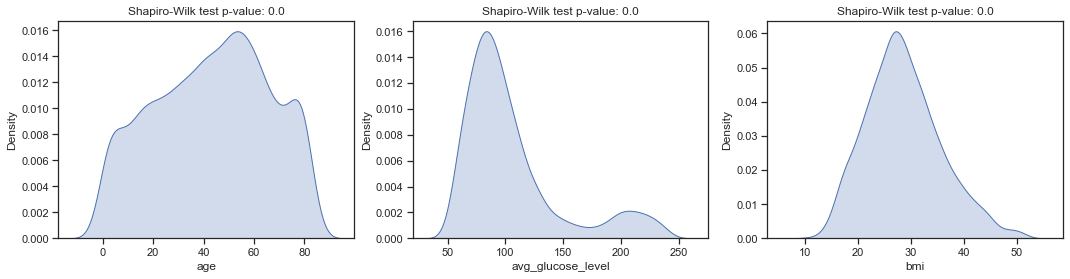

In [18]:
df['avg_glucose_level'] = outliers_killer(df['avg_glucose_level'])
df['bmi'] = outliers_killer(df['bmi'])

column = 0
fig, axs = plt.subplots(1,3)
for variable in df.loc[:,df.dtypes == 'float64'].columns:
    sns.kdeplot(df[variable], ax = axs[column], fill = True)
    axs[column].set_title(f'Shapiro-Wilk test p-value: {round(sp.shapiro(df[variable].sample(1000)).pvalue, 3)}')
    column += 1

По-моему, стало лучше.

### Проверка гипотез

Построим барчарты для наших гипотез:

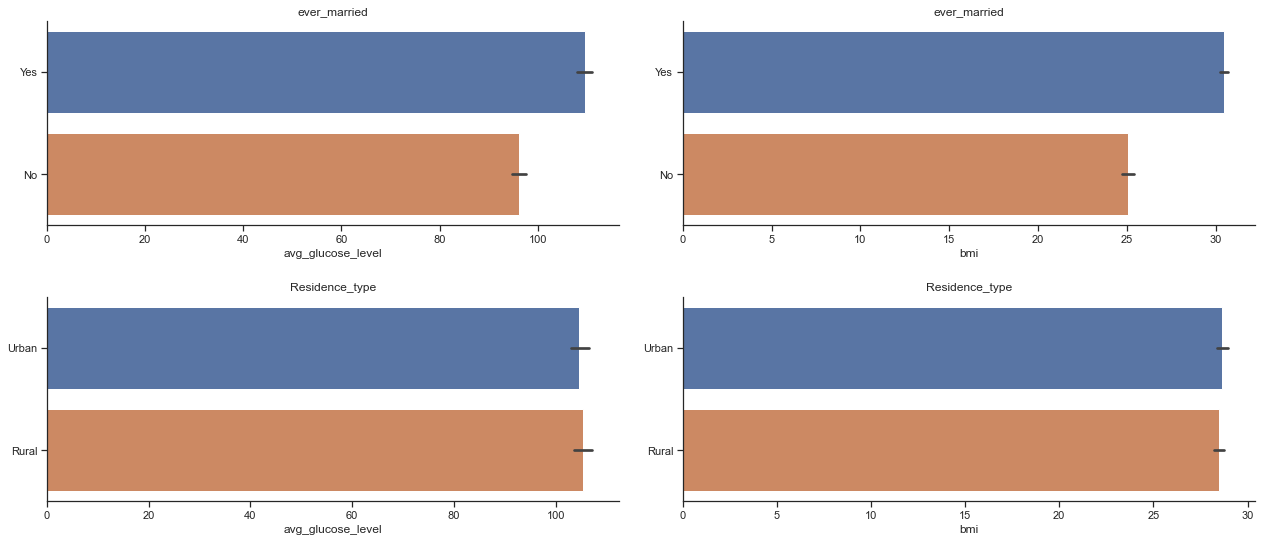

In [19]:
categories = ['ever_married', 'Residence_type']

custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize': (18, 8)}
sns.set_theme(style = "ticks", rc = custom_params)
fig, axs = plt.subplots(2,2)

row = 0
for category in categories:
    sns.barplot(x = 'avg_glucose_level', y = category, data = df, ax = axs[row, 0])
    sns.barplot(x = 'bmi', y = category, data = df, ax = axs[row, 1])
    axs[row, 0].set_title(f'{category}')
    axs[row, 1].set_title(f'{category}')
    axs[row, 0].set_ylabel('')
    axs[row, 1].set_ylabel('')
    row += 1
   
fig.tight_layout(pad=2)
plt.show()

Различия по браку наглядны, но лучше оценить количественно с помощью тестов. Я буду использовать и т-тест, и тест Мана-Уитни:

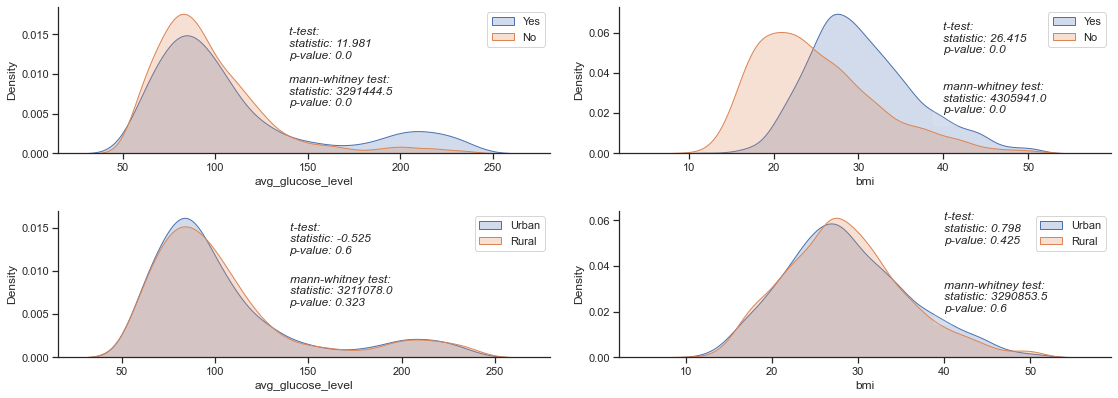

In [20]:
# подготовим данные
data_avg_glucose_level_married = df.query('ever_married == "Yes"').avg_glucose_level 
data_avg_glucose_level_not_married = df.query('ever_married == "No"').avg_glucose_level
data_bmi_married = df.query('ever_married == "Yes"').bmi
data_bmi_not_married = df.query('ever_married == "No"').bmi
data_avg_glucose_level_urban = df.query('Residence_type == "Urban"').avg_glucose_level
data_avg_glucose_level_rural = df.query('Residence_type == "Rural"').avg_glucose_level
data_bmi_urban = df.query('Residence_type == "Urban"').bmi
data_bmi_not_rural = df.query('Residence_type == "Rural"').bmi
a = [data_avg_glucose_level_married, data_avg_glucose_level_urban]
b = [data_avg_glucose_level_not_married, data_avg_glucose_level_rural]
c = [data_bmi_married, data_bmi_urban]
d = [data_bmi_not_married, data_bmi_not_rural]


labels = [df.ever_married.unique(), df.Residence_type.unique()]
    
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize': (16, 6)}
sns.set_theme(style = "ticks", rc = custom_params)    

fig, axs = plt.subplots(2,2) 
for i in range(2):
    
    # проведем статистические тесты
    ttest_stat_ab, ttest_pval_ab = sp.ttest_ind(a[i], b[i], equal_var = False, alternative = 'two-sided')
    mu_stat_ab, mu_pval_ab = sp.mannwhitneyu(a[i], b[i], alternative = 'two-sided')
    ttest_stat_cd, ttest_pval_cd = sp.ttest_ind(c[i], d[i], equal_var = False, alternative = 'two-sided')
    mu_stat_cd, mu_pval_cd = sp.mannwhitneyu(c[i], d [i], alternative = 'two-sided')
    
    # нарисуем 
    sns.kdeplot(a[i], fill = True, ax = axs[i, 0])
    sns.kdeplot(b[i], fill = True, ax = axs[i, 0])
    axs[i, 0].set_title('')
    axs[i, 0].set_xlabel(a[i].name)
    axs[i, 0].legend(labels[i])
    axs[i, 0].text(140, 0.012, f'''t-test: \nstatistic: {round(ttest_stat_ab, 3)} \np-value: {round(ttest_pval_ab, 3)}''', style = 'oblique',
                bbox = {'facecolor': 'white', 'alpha': 0.1, 'pad': 10})
    axs[i, 0].text(140, 0.006, f'''mann-whitney test: \nstatistic: {round(mu_stat_ab, 3)} \np-value: {round(mu_pval_ab, 3)}''', style = 'oblique',
                bbox = {'facecolor': 'white', 'alpha': 0.1, 'pad': 10})
    
    sns.kdeplot(c[i], fill = True, ax = axs[i, 1])
    sns.kdeplot(d[i], fill = True, ax = axs[i, 1])
    axs[i, 1].set_title('')
    axs[i, 1].set_xlabel(c[i].name)
    axs[i, 1].legend(labels[i])
    axs[i, 1].text(40, 0.05, f'''t-test: \nstatistic: {round(ttest_stat_cd, 3)} \np-value: {round(ttest_pval_cd, 3)}''', style = 'oblique',
                bbox = {'facecolor': 'white', 'alpha': 0.1, 'pad': 10})
    axs[i, 1].text(40, 0.02, f'''mann-whitney test: \nstatistic: {round(mu_stat_cd, 3)} \np-value: {round(mu_pval_cd, 3)}''', style = 'oblique',
                bbox = {'facecolor': 'white', 'alpha': 0.1, 'pad': 10})
    
fig.tight_layout(pad=2)
    
    

**Выводы:**

Гипотезы номер 1 и 2 подтвердились - у тех, кто находится в браке, уровень сахара в крови в среднем выше, чем у тех, кто в браке не находится. Также у людей в браке в среднем выше индекс массы тела, это подтверждают как параметрические(т-тест), так и непараметрические(тест Мана-Уитни) методы.

Статистически значимой взаимосвязи между уровнем урбанизации и уровнем сахара в крови/индексом массы тела выявить не удалось.

### Логистическая регрессия

Преобразуем категориальные переменные в дамми:

In [21]:
df['gender'] = LabelEncoder().fit_transform(df['gender'])
df['ever_married'] = LabelEncoder().fit_transform(df['ever_married'])
df = pd.get_dummies(df, columns = ['work_type'])
df = pd.get_dummies(df, columns = ['Residence_type'])
df = pd.get_dummies(df, columns = ['smoking_status'])

In [22]:
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,228.69,36.600000,1,0,0,1,0,0,0,1,1,0,0
1,0,61.0,0,0,1,202.21,35.815574,1,0,0,0,1,0,1,0,0,1,0
2,1,80.0,0,1,1,105.92,32.500000,1,0,0,1,0,0,1,0,0,1,0


Выборка не сбалансирована. Используем oversampling для получения сбалансированной выборки:

Before OverSampling, counts of label '1': 249
Before OverSampling, counts of label '0': 4861
After OverSampling, counts of label '1': 4861
After OverSampling, counts of label '0': 4861


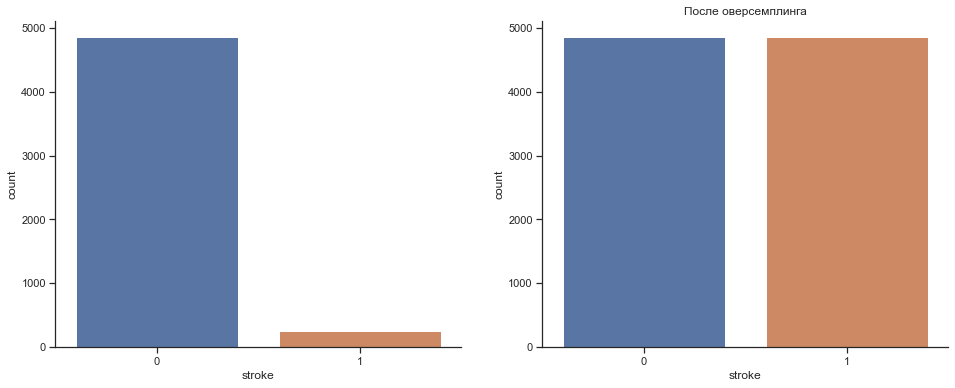

In [23]:
fig, axs = plt.subplots(1,2)
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize': (16, 2)}
sns.set_theme(style = "ticks", rc = custom_params) 

sns.countplot(x = 'stroke', data = df, ax = axs[0])
plt.title('До оверсемплинга')

X = df.drop('stroke', axis = 1)
y = df.stroke

sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)

print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {}".format(sum(y==0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))

sns.countplot(x = y_res, data = df, ax = axs[1])
plt.title('После оверсемплинга')
plt.show()

Теперь мы можем ориентироваться на такую метрику качества, как accuracy. Также, для более полной картины, в итоговую выписку результатов модели будут включены другие метрики (precision, recall, f1-score)

Разделим данные на обучающую и тестовую выборки:

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 42)

Стандартизируем значения признаков с помощью Z-преобразования, поскольку они имеют неодинаковую размерность:

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучим модель:

In [26]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

Посмотрим на метрики качества модели:

In [27]:
print(confusion_matrix(lr_pred, y_test))
print('------------------------------------------------------')
print(classification_report(lr_pred, y_test))

[[958 103]
 [ 17 867]]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1061
           1       0.89      0.98      0.94       884

    accuracy                           0.94      1945
   macro avg       0.94      0.94      0.94      1945
weighted avg       0.94      0.94      0.94      1945



На мой взляд, модель неплохая :)